# Détection de fraudes de cartes de crédit

## 1 Introduction

La détection de fraudes par cartes de crédit est un sujet de recherche majeur en finance ayant des répercussions économiques importantes. Il est important que les sociétés de carte de crédit puissent reconnaître les transactions frauduleuses pour que leurs clients ne soient pas facturés pour des articles qu'ils n'ont pas achetés. L'objectif du projet est d'explorer différents algorithmes de classification en apprentissage automatique capables de détecter les fraudes dans un ensemble de transactions bancaires. Le [jeu de données](https://www.kaggle.com/mlg-ulb/creditcardfraud) étudié dans le cadre du projet est un jeu de données kaggle de transactions par cartes de crédit.

En pratique, les fraudes sont ponctuelles et sous représentées dans le jeu de données qui contient principalement des transactions normales. L'implémentation des modèles et les métriques de mesures de performance utilisées doivent être adaptées aux données fortement débalancées. C'est la raison pour laquelle on étudiera différentes méthodes qui permettent de traiter des jeux de donnés caractérisés par un déséquilibre marqué entre les classes dans un contexe de classification.

D'autre part, il est également souhaitable que la classification soit sensible, c’est-à-dire que le taux de transactions classées à tort comme des fraudes soit minimal puisque l'institution bancaire ne veut pas déranger inutilement ces clients.


## 2 Plan

* [3 Données](#Donnees)
* [4 Méthodologie](#Methodologie)
  * 4.1 Fonctions utilitaires
* [5 Normalisation](#Normalization)
* [6 Séparation des données](#Split)
* [7 Régression logistique (implémentation naïve)](#Reg)
  * 7.1 Sélection des hyperparamètres
  * 7.2 Évaluation sur les données test
* [8 Sous-échantillonnage](#Us)
  * 8.1 Sous-échantillonnage aléatoire
    * 8.1.1 Sélection du modèle 
  * 8.2 Sous échantillonnage par centroïdes
    * 8.2.1 Sélection des hyperparamètres
  * 8.3 Évaluation sur les données test (sous-échantillonnage aléatoire)
* [9 Sur-échantillonnage synthétique](#Smote)
  * 9.1 SMOTE
    * 9.1.1 Sélection des hyperparamètres
  * 9.2 ADASYN
    * 9.2.1 Sélection des hyperparamètres
  * 9.3 Évaluation sur les données test (SMOTE)
* [10 Sur-échantillonnage avec autoencodeur variationnel](#Vae)
  * 10.1 Théorie
  * 10.2 Implémentation
  * 10.3 Régression logistique

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time as t
import warnings
warnings.filterwarnings("ignore")

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterGrid

# Resampling
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.over_sampling import SMOTE, ADASYN

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

# Performance metrics
from sklearn.metrics import precision_recall_fscore_support,\
                            accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

# TensorFlow
import tensorflow as tf
import tensorflow_probability as tfp
tfpd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


<a id="Donnees"></a>
## 3 Données

Le jeu de données contient 284 807 exemples ayant chacun 30 traits caractéristiques numériques dont le temps et le montant de la transaction. Les 28 autres proviennent d'une analyse en composante principale (PCA) effectuée pour anonymiser les données. Très sommairement, une analyse en composante principale est une réduction de dimensionalité qui consiste à projeter les variables initiales sur des nouvelles variables décorrélés qu'on appelle les composantes principales.

Les exemples non-frauduleux sont étiquetés par la classe 0 et les exemples frauduleux par la classe 1. Seulement 492 (0.173%) des exemples sont de la classe 1.

In [2]:
df = pd.read_csv("data/creditcard.csv")
print('shape: ', df.shape)
df.head(n=5)

shape:  (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
count = df['Class'].value_counts().to_frame()
count['Ratio'] = count['Class'].apply(lambda x: np.around(x/len(df)*100, 3))
count.insert(0, 'Label', ['Non-fraud', 'fraud'])
count

,Label,Class,Ratio
0,Non-fraud,284315,99.827
1,fraud,492,0.173


Les colonnes `Time` et `Amount` sont les plus asymétriques, les autres sont normalisées. Ci-bas les histogrammes de chaque trait caractéristique des données en fonction des classes. Ils illustrent que certains traits caractéristiques semblent plus discriminatifs que d'autres qui sont plus confondus pour les deux classes.

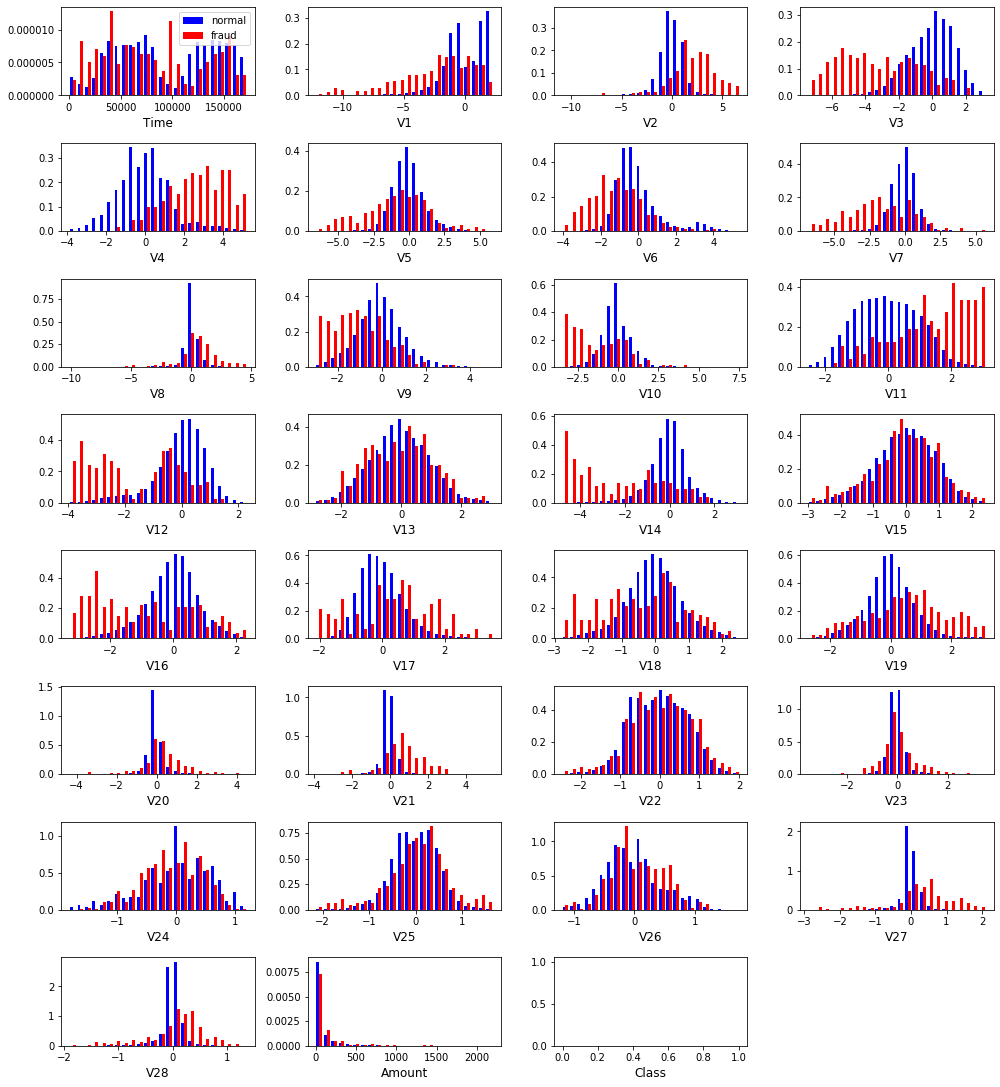

In [5]:
n_features = df.shape[1] #- 1 
n_cols = 4
n_rows = n_features // n_cols + 1

# create a figure and a set of subplots
axarr = [[]]*n_features
fig, ax = plt.subplots(figsize=(n_cols*3.5, n_rows*2))

for i, col in enumerate(df):
    # Create an axis at specific location inside a regular grid.
    axarr[i] = plt.subplot2grid( shape=(n_rows, n_cols), loc=(i // n_cols, i % 4))
    # Generate histograms
    # bins are 25 evenly spaced numbers between 0.2 and 99.8 perceniles (not including extreme values)
    bins = np.linspace(start=np.percentile(df[col], 0.2), stop=np.percentile(df[col], 99.8), num=25)
    axarr[i].hist(x=[df.loc[df.Class == 0, col], df.loc[df.Class == 1, col]],
                  label=['normal', 'fraud'],
                  bins=bins,
                  color=['blue', 'red'],
                  normed=True)
    axarr[i].set_xlabel(col, size=12)
    if i == 0: 
        legend = axarr[i].legend()

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
plt.show()

<a id="Methodologie"></a>

## 4 Méthodologie

Un classifieur entraîné sur des données grandement débalancées risque de mémoriser la disproportion des classes et d'apprendre alors à voter majoriatirement pour la classe sur-représentée. Un tel classifieur sur-apprend la distribution et ignore les traits caractéristiques permettant véritablement de discriminer entre les classes. Considérons l'exemple d'un classifieur qui prédit toujours la classe 0 pour le présent problème de détection de fraudes. Il réussit à prédire correctement la classe de 99.827% transactions, sans pourtant ne détecter aucune fraude. Ce classifieur est incapable de généraliser, et ce, même si son taux de classifications est élevé. C'est la raison pour laquelle il faut adapter l'entraînement des classifieurs et évaluer leurs performances avec les métriques appropriées.

Pour minimiser le risque de sur-apprentissage lié au déséquilibre des données, il est possible de ré-échantillonner l'ensemble des données afin de l'équilibrer. L'idée est d'entraîner un modèle sur un ensemble de données balancé tel quel 50% des données sont des fraudes. Modifier ainsi les données d'entraînement introduit un biais qui sert à compenser le risque de surapprentissage dû au fléau des données débalancées. 

Le sous-échantillonnage est une méthode de ré-échantillonnage qui consiste à retirer une partie des données de la classe majoritaire avant d'entraîner un classifieur. Inversement, le sur-échantillonnage consiste à augmenter les données de la classe minoritaire. On présentera plusieurs méthodes de ré-échantillonnge pour parvenir à reconnaître les fraudes. 

D'autre part, voici une liste énumérant les définitions de différentes métriques pour mesurer la performance des algorithmes de classification basées sur les notions de vrai positif, faux positif, vrai négatif et faux négatif.

- vrais positifs (VP): Nombre de fraudes classées correctement.


- faux positifs (FP): Nombre de non-fraudes classées incorrectement.


- vrais négatifs (VN): Nombre de non-fraudes classées correctement.


- faux négatifs (FN): Nombre de fraudes classées incorrectement.

Note: On peut aussi énoncer les définitions pour VP, FP, VN et FN symétriquement pour la classe non-fraude.

Soit $N$ le nombre total d'exemples.

- Taux de bonnes classifications (accuracy) $:=\frac{VP+VN}{N}$


- Précision (precision) $:=\frac{VP}{VP+FP}$


- Rappel (recall) $:=\frac{VP}{VP+FN}$


- Score-f1 (f1-score)$:=2\ \frac{\text{précision}\ \times\ \text{rappel}}{\text{précision}\ +\ \text{rappel}}$


- Courbe ROC: Courbe de VP en fonction de FP pour un classifieur binaire.


- Roc Auc Score: Aire sous la courbe ROC.


Le taux de bonnes classifications est peut-être la mesure la plus naturelle lorsque le jeu de données est balancé. Par contre, on a vu qu'il peut être trompeur si les classes sont disproportionnées.

La précision et le rappel sont des mesures de performance appropriées dans le cas de données débalancées. La précision est une mesure d'exactitude qui correspond à la proportion des items pertinents parmi l'ensemble des items proposés. Dans notre cas, il s'agit de l'ensemble des fraudes détectées parmi l'ensemble des transactions classées comme fraudes. D'autre part, le rappel (ou sensibilité) est une mesure d'exhaustivité. Le rappel est la proportion des items pertinents proposés parmi l'ensemble des items pertinents. C'est-à-dire qu'il s'agit de l'ensemble des fraudes détectées parmi l'ensemble de toutes les fraudes. C'est le taux de bonnes classifications par classe. 

Dans les cas extrêmes, la précision et le rappel s'échangent l'un pour l'autre sous la forme d'un compromis. Par exemple, si on prédit une seule fraude comme une fraude et toutes les autres transactions comme des non-fraudes, alors la précision est de 100%, mais le rappel est très proche de 0%. Inversement, si on prédit toutes les transactions comme des fraudes, alors le rappel est de 100%, mais la précision est très basse. Le score-f1 est la moyenne harmonique de la précision et du rappel qui quantifie le compromis entre la précision et le rappel. 

Si la probabilité associée à chaque classe est disponible, alors il est possible de tracer la courbe de la précision en fonction du rappel pour différents seuils de classification. Il est également possible de tracer la courbe ROC qui est le taux de vrais positifs en fonction du taux de faux négatifs calculés pour différents seuils de classification. 

### Fonctions utilitaires

Il faut être vigilant lorsqu'on applique les méthodes de ré-échantillonnage puisqu'elles modifient la distribution des données. Supposons qu'on utilise une technique de sur-échantillonnage qui duplique aléatoirement des exemples de la classe minoritaire. Si on sur-échantillonne avant de séparer les données en ensembles d'entraînement et de test, alors il probable qu'un exemple soit dans l'ensemble d'entraînement mais que sa copie soit dans l'ensemble de test. Ainsi, l'ensemble de test n'est pas complètement inconnu à un classifieur qui s'entraîne sur cet ensemble d'entraînement. Pour éviter une telle fuite d'information future et l'introduction d'un biais dans l'estimation de performance, il faut s'assurer que l'ensemble de test soit indépendant de l'ensemble d'entraînement et que sa distribution soit celle des données initiales. C'est aussi valable lors de la validation croisée: il faut que les méthodes de ré-échantillonnage s'appliquent autant que possible sur l'ensemble d'entraînement sans affecter l'ensemble de validation.

La fonctionalité `grid_search_cv_resample` permet de faire une fouille exhaustive sur un dictionnaire d'hyper-paramètres tout en ré-échantillonnant durant la validation croisée. La méthode  `GridSearchCV` de Scikit Learn est plus rapide d'éxécution mais ne permet pas de ré-échantillonner à chaque pli de la validation croisée. On peut utiliser `GridSearchCV` avec les méthodes de sous-échantillonnage qui prenne du temps à s'éxécuter puisqu'elles n'introduisent pas d'information de l'ensemble d'entraînement dans l'ensemble de test.

La fonctionalité `print_metrics_resample` permet d'imprimer une estimation de la performance d'un prédicteur par validation croisée.

In [6]:
metrics = {}
metrics['accuracy'] = accuracy_score
metrics['recall'] = recall_score

def grid_search_cv_resample(X_train, y_train, model, params, cv=5, resampler=None, metric='accuracy', verbose=True):
    """
    Returns the best model found by cross validation.
    """
    # Folds are made by preserving the percentage of samples for each class.
    skf = StratifiedKFold(n_splits=cv, shuffle=False)

    param_grid = ParameterGrid(params)
    best_params = None
    best_score = 0
    
    scoring = metrics[metric]
    
    time1 = t()
    for param_combination in param_grid:
        
        # Set model parameters
        model.set_params(**param_combination)
        
        scores = []
        
        # Cross validation
        for train_index, val_index in skf.split(X_train, y_train):
            
            # Train-val split
            X_val, y_val = X_train[val_index], y_train[val_index] 
            X_train_resample, y_train_resample = X_train[train_index], y_train[train_index]
            # Re-sample training set
            if resampler is not None:
                X_train_resample, y_train_resample = resampler.fit_resample(X_train_resample, y_train_resample)
            
            # Train - predict on validation
            model.fit(X_train_resample, y_train_resample)
            pred = model.predict(X_val)
            
            # Evaluate performance
            scores.append(scoring(y_val, pred))
            # Only report results for the class specified by pos_label (default=1).

        score = np.mean(scores)
        
        if score > best_score:
            best_score, best_params = score, param_combination

    time2 = t()
    if verbose:
        print('\nBest params', best_params)
        print(f'{metric} score:', best_score)
        print('Time:', time2-time1)
    
    return model.set_params(**best_params)


def print_metrics_resample(X, y, model, cv=5, resampler=None):
    
    # Folds are made by preserving the percentage of samples for each class.
    skf = StratifiedKFold(n_splits=cv, shuffle=False)
    
    precision = []
    recall = []
    f1 = []
    support = []
    accuracy = []
    
    # Cross validation
    for train_index, val_index in skf.split(X, y):

        # Train-val split
        X_val, y_val = X[val_index], y[val_index] 
        X_train_resample, y_train_resample = X[train_index], y[train_index]
        # Re-sample training set
        if resampler is not None:
            X_train_resample, y_train_resample = resampler.fit_resample(X_train_resample, y_train_resample) # Shuffle this ?! 

        # Train - predict on validation
        model.fit(X_train_resample, y_train_resample)
        pred = model.predict(X_val)

        # Evaluate performance
        metrics = precision_recall_fscore_support(y_val, pred, beta=1.0, labels=[0,1], average=None)
        precision.append(metrics[0])
        recall.append(metrics[1])
        f1.append(metrics[2])
        support.append(metrics[3])
        accuracy.append(accuracy_score(y_val, pred))
    
    precision = np.mean(precision, axis=0)
    recall = np.mean(recall, axis=0)
    f1 = np.mean(f1, axis=0)
    support = np.mean(support, axis=0)
    accuracy = np.mean(accuracy, axis=0)
    
    print('\nAccuracy\t', accuracy)
    print('\nClass\t\t 0\t\t1')
    print('Precision\t', '%.3f\t\t%.3f'% (precision[0], precision[1]))
    print('Recall\t\t', '%.3f\t\t%.3f'% (recall[0], recall[1]))
    print('f1\t\t', '%.3f\t\t%.3f'% (f1[0], f1[1]))
    print('Support\t\t', '%.3f\t%.3f'% (support[0], support[1]))


<a id="Normalization"></a>
##  5 Normalisation

On voudrait normaliser les colonnes `Time` et `Amount` comme pour les colonnes `V1` à `V28`. Le but principal de cette normalisation est d'aider les techniques de convergence utilisées pour l'optimisation.

In [7]:
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()

time = df['Time'].values.reshape(-1, 1)
amount = df['Amount'].values.reshape(-1, 1)
norm_time = scaler.fit_transform(time)
norm_amount = scaler.fit_transform(amount)
df.insert(0, 'norm_time', norm_time)
df.insert(0, 'norm_amount',norm_amount)
df.drop(['Time', 'Amount'], axis=1, inplace=True)
df.head()

,norm_amount,norm_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.244964,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.342475,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.160686,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,0.140534,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.073403,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


<a id="Split"></a>
## 6 Séparation des données

In [8]:
inputs, outputs = df.drop('Class', axis=1), df['Class']

# If stratify not None, data is split in a stratified fashion, using this as the class labels
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.3, random_state=0, stratify=outputs)

# Verify if distributions are the same
n_train_fraud = y_train.value_counts()[1]
n_test_fraud = y_test.value_counts()[1]
train_ratio = n_train_fraud/y_train.shape[0] * 100
test_ratio = n_test_fraud/y_test.shape[0] * 100
print(f'{n_train_fraud} cas de fraudes dans l\'ensemble d\'entraînement ({train_ratio} %)')
print(f'{n_test_fraud} cas de fraudes dans l\'ensemble de test ({test_ratio} %)')

# Create a new dataframe for training set
train_df = X_train.copy()
train_df['Class'] = y_train
train_df.sample(random_state=0)

X_train, y_train = X_train.values, y_train.values
X_test, y_test = X_test.values, y_test.values

344 cas de fraudes dans l'ensemble d'entraînement (0.17254870488152324 %)
148 cas de fraudes dans l'ensemble de test (0.17321489179921118 %)


<a id="Reg"></a>
## 7 Régression logistique (implémentation naïve)

Pour commencer, implémentons naïvement un classifieur simple comme la régression logistique sur la totalité des données sans se préoccuper du débalancement des données. Comme discuté précédemment, on s'attend à ce que le modèle apprenne à prédire la classe 0 trop souvent.

### 7.1 Sélection des hyperparamètres

In [9]:
log_reg = LogisticRegression()

# Tuning penalty and regularization using cross validation (5 folds)
params = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
log_reg_gs= GridSearchCV(log_reg, params, scoring='accuracy', cv=5, verbose=1) # Using accuracy as scoring metric 
log_reg_gs.fit(X_train, y_train)
print('Meilleurs paramètres:', log_reg_gs.best_params_)
print('Meilleur résultat (moyenne des résultats de validation croisée):', log_reg_gs.best_score_)
log_reg_best = log_reg_gs.best_estimator_

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   59.4s finished


Meilleurs paramètres: {'C': 10, 'penalty': 'l2'}
Meilleur résultat (moyenne des résultats de validation croisée): 0.9992375756661026


### 7.2 Évaluation sur les données test

On estime le pouvoir de généralisation du classifieur sur l'ensemble de test. Bien que le taux de bonnes classification est élevée, le prédicteur n'a su que détecter 63% des fraudes. Ceci confirme notre hypothèse et on voudrait augmenter significativement cette quantité.

In [10]:
log_reg_best.fit(X_train, y_train)
predictions = log_reg_best.predict(X_test)

print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     85295
           1     0.8774    0.6284    0.7323       148

    accuracy                         0.9992     85443
   macro avg     0.9384    0.8141    0.8659     85443
weighted avg     0.9991    0.9992    0.9991     85443



<a id="Us"></a>
## 8 Sous-échantillonnage

### 8.1 Sous-échantillonnage aléatoire

Le sous-échantillonnage aléatoire consiste à sélectionner aléatoirement des exemples dans la classe majoritaire pour équilibrer les données. 

Ci-bas les matrices de corrélations du jeu de donnée débalancé et du jeu de donné balancé avec sous-échantillonnage aléatoire. Les corrélations sont plus évidentes dans le jeu de données balancé de sorte que le sous-échantillonnage aléatoire devrait aider les classifieurs à cerner les attributs permettant d'établir une différence entre les classe.

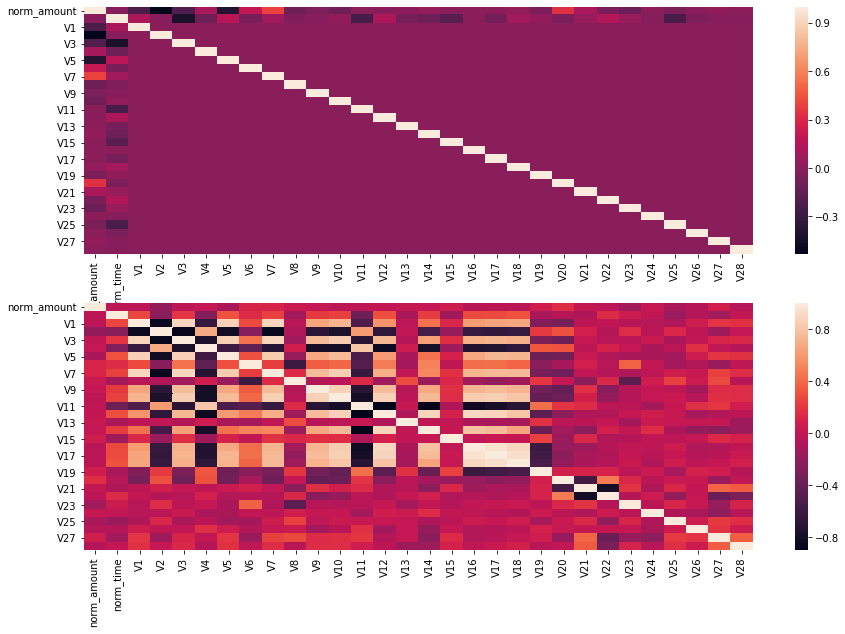

In [11]:
# Make sure we use the subsample in our correlation
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Original unbalanced dataframe
unbalanced_df = df.drop(["Class"], axis=1)
sns.heatmap(unbalanced_df.corr(), ax=ax1)

# Balanced dataframe
rand_undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=0)
X_us, y_us = rand_undersampler.fit_resample(X_train, y_train)

balanced_df = pd.DataFrame(X_us)
balanced_df.columns = unbalanced_df.columns
sns.heatmap(balanced_df.corr(), ax=ax2)


#### 8.1.1 Sélection du modèle 

Comme le jeu de donné sous-échantillonné est petit, il devrait avoir une grande variabilité. C'est pourquoi il est raisonnable d'essayer des modèles de basse capacité. Un algorithme trop expressif risque de mémoriser le bruit, de surapprendre et de mal généraliser.

Le rappel est une mesure de performance naturelle pour choisir les hyperparamètres des modèles lors de la validation croisée puisque l'ensemble de validation est débalancé.

In [12]:
# Logistic Regression
log_reg = LogisticRegression()

# Tuning penalty and regularization using cross validation
params = {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
log_reg_us = grid_search_cv_resample(X_train,
                                     y_train,
                                     log_reg,
                                     params,
                                     cv=5,
                                     resampler=rand_undersampler,
                                     metric='recall',
                                     verbose=True)


Best params {'C': 1000, 'penalty': 'l2'}
recall score: 0.9303069053708439
Time: 5.384169101715088


In [13]:
print_metrics_resample(X_train, y_train, log_reg_us, cv=5, resampler=rand_undersampler)


Accuracy	 0.9498605647670519

Class		 0		1
Precision	 1.000		0.031
Recall		 0.950		0.930
f1		 0.974		0.060
Support		 39804.000	68.800


In [14]:
# SVM
svm_rbf = SVC()

# Tuning kernel, C, and degree for polynomial kernel
params = {'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
svm_rbf_us = grid_search_cv_resample(X_train,
                                     y_train,
                                     svm_rbf, 
                                     params,
                                     cv=5,
                                     resampler=rand_undersampler,
                                     metric='recall',
                                     verbose=1)


Best params {'C': 1000, 'kernel': 'rbf'}
recall score: 0.9331202046035806
Time: 21.826516151428223


In [15]:
print_metrics_resample(X_train, y_train, svm_rbf_us, cv=5, resampler=rand_undersampler)


Accuracy	 0.9426676802076932

Class		 0		1
Precision	 1.000		0.028
Recall		 0.943		0.933
f1		 0.970		0.054
Support		 39804.000	68.800


In [16]:
# knn
knn = KNeighborsClassifier()

# Tuning k
params = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
knn_us = grid_search_cv_resample(X_train,
                                 y_train,
                                 knn,
                                 params,
                                 cv=5,
                                 resampler=rand_undersampler,
                                 metric='recall',
                                 verbose=1)


Best params {'n_neighbors': 1}
recall score: 0.9128303495311169
Time: 105.61243295669556


In [17]:
print_metrics_resample(X_train, y_train, knn_us, cv=5, resampler=rand_undersampler)


Accuracy	 0.9360766891038759

Class		 0		1
Precision	 1.000		0.024
Recall		 0.936		0.913
f1		 0.967		0.047
Support		 39804.000	68.800


In [18]:
# Random Forest
rand_forest = RandomForestClassifier(random_state=0)

# Tuning number of trees
params = {'n_estimators': [1, 10, 100, 500]}
rand_forest_us = grid_search_cv_resample(X_train,
                                         y_train,
                                         rand_forest,
                                         params,
                                         cv=5,
                                         resampler=rand_undersampler,
                                         metric='recall',
                                         verbose=1)


Best params {'n_estimators': 100}
recall score: 0.9128729752770675
Time: 16.865888118743896


In [19]:
print_metrics_resample(X_train, y_train, rand_forest_us, cv=5, resampler=rand_undersampler)


Accuracy	 0.9717953071427143

Class		 0		1
Precision	 1.000		0.054
Recall		 0.972		0.913
f1		 0.986		0.101
Support		 39804.000	68.800


Les classifieurs donnent tous de bons résultats pour le rappel et le taux de bonnes classifications global. Par contre, pour la classe 1, la précision et le score-f1 sont assez bas.

La forêt d'arbres aléatoires a le plus haut taux de bonnes classifications (\~97%) avec un rappel raisonable (\~91%) pour la classe des fraudes. Si on se place dans la position d'une institution bancaire qui se satisfait d'un taux de détection de fraude > 90%, mais qui désire limiter absolument le taux de cas non-fraduleux incorrectement classés pour ne pas déranger inutilement sa clientèle, alors la forêt d'arbres aléatoires est le classifieur le plus intéressant.

### 8.2 Sous-échantillonnage par centroïdes

Il s'agit de performer l'algorithme de K-Moyennes (K-Mean) sur l'ensemble majoritaire pour sélectionner les exemples à conserver.

L'algorithme K-moyenne trouve le barycentre des exemples de la classes majoritaires et les exemples les plus éloignés du centroïde sont considérés comme les moins importants de sorte qu'on les retire.

Cette méthode s'assure alors de sélectioner des éléments typiques qui devraient bien représenter la classe majoritaire.

#### 8.2.1 Sélection des hyperparamètres

In [20]:
centroid_undersampler = ClusterCentroids(sampling_strategy='majority', random_state=0)

# Perform under-sampling by generating centroids based on clustering methods.
X_train_centroid, y_train_centroid = centroid_undersampler.fit_resample(X_train, y_train)

In [21]:
log_reg = LogisticRegression()
params = {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
log_reg = GridSearchCV(log_reg, params, scoring='accuracy', cv=5, verbose=1)
log_reg.fit(X_train_centroid, y_train_centroid)
print(log_reg.best_params_)
print('Meilleur résultat (moyenne des résultats de validation croisée):', log_reg.best_score_)
log_reg_centroid = log_reg.best_estimator_

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'C': 1, 'penalty': 'l2'}
Meilleur résultat (moyenne des résultats de validation croisée): 0.9360414683169365


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.7s finished


Estimation (fiable) de la performance avec un ensemble de validation ayant la distribution initiale.

In [22]:
print_metrics_resample(X_train, y_train, log_reg_centroid, cv=5, resampler=centroid_undersampler)


Accuracy	 0.9618537132381668

Class		 0		1
Precision	 1.000		0.039
Recall		 0.962		0.898
f1		 0.981		0.076
Support		 39804.000	68.800


### 8.3 Évaluation sur les données test (sous-échantillonnage aléatoire)

La régression logistique a un taux de classification acceptable tout en ayant un bon rappel. Co-bas se trouve l'évaluation de son pouvoir de généralisation avec sous-échantillonnage aléatoire sur l'ensemble de test original.

Les résultats sont bons et s'accordent à ceux prédits par la validation croisée sur l'ensemble d'entraînement.

In [23]:
# Under-sampled training set
X_train_rus, y_train_rus = rand_undersampler.fit_resample(X_train, y_train)

In [24]:
log_reg_us.fit(X_train_rus, y_train_rus)
predictions = log_reg_us.predict(X_test)
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9998    0.9263    0.9616     85295
           1     0.0209    0.9054    0.0408       148

    accuracy                         0.9262     85443
   macro avg     0.5103    0.9158    0.5012     85443
weighted avg     0.9981    0.9262    0.9600     85443



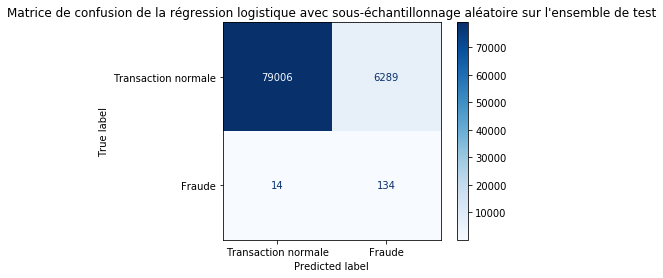

In [25]:
# Confusion matrix
np.set_printoptions(precision=2)

disp = plot_confusion_matrix(log_reg_us,
                             X_test,
                             y_test,
                             display_labels=["Transaction normale", "Fraude"],
                             values_format='.6g',
                             cmap=plt.cm.Blues,
                             normalize=None)
disp.ax_.set_title('Matrice de confusion de la régression logistique avec sous-échantillonnage aléatoire sur l\'ensemble de test')

plt.show()

In [26]:
roc_auc_reg = roc_auc_score(y_test, predictions)
print('Roc Auc score', roc_auc_reg)

Roc Auc score 0.9158365323527409


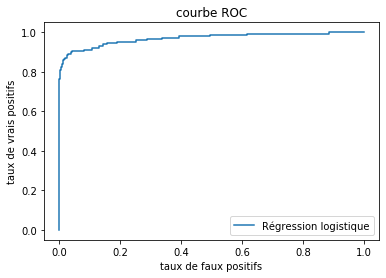

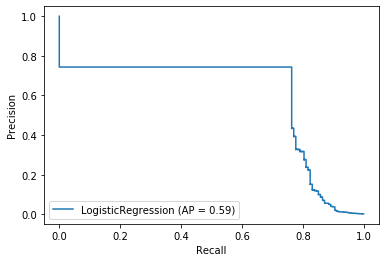

In [27]:
decision_function = log_reg_us.decision_function(X_test)

# ROC curve
log_reg_fpr, log_reg_tpr, log_reg_thresholds = roc_curve(y_test, decision_function)

plt.title('courbe ROC')
plt.plot(log_reg_fpr, log_reg_tpr, label='Régression logistique')
plt.xlabel('taux de faux positifs')
plt.ylabel('taux de vrais positifs')
plt.legend(loc='best')
plt.show()

# Precision-Recall curve
plot_precision_recall_curve(log_reg_us, X_test, y_test)

In [28]:
# thresholds = np.arange(0, 100, 10)/100 # For fraud

# predictions_proba = log_reg_us.predict_proba(X_test)[:,-1]

# for threshold in thresholds:
#     # Prediction
#     predictions = (predictions_proba >= threshold).astype(int)
    
#     # Quality 
#     confusion_m = confusion_matrix(y_test, predictions)
#     tn, fp, fn, tp = confusion_m.ravel()
#     print('\nThreshold=', threshold)
#     print('Accuracy=', accuracy_score(y_test, predictions))
#     print('true positives\tfalse positives\tfalse negatives\ttrue negatives')
#     print('%.0f\t\t%.0f\t\t%.0f\t\t%.0f'% (tn, fp, fn, tp))
#     print('Precision=', precision_score(y_test, predictions))
#     print('Recall=', recall_score(y_test, predictions))

<a id="Smote"></a>
## 9 Sur-échantillonnage synthétique

### 9.1 SMOTE

Smote [\[2\]](#smote) est une méthode de sur-échantillonnage. La classe minoritaire est augmentée en ajoutant des exemples synthétiques sur les lignes séparant les exemples de leurs plus proches voisins. Les exemples synthétiques sont générés en prenant la différence entre l'exemple courant et un de ses plus propres voisins. La différence est multipliée par un nombre aléatoire entre 0 et 1 pour finalement être additionnée à l'exemple considéré. Ceci revient à créer un exemple synthétique le long du segment rejoignant l'exemple de son voisin.
<img src="https://www.researchgate.net/publication/287601878/figure/fig1/AS:316826589384744@1452548753581/The-schematic-of-NRSBoundary-SMOTE-algorithm.png" alt="Smote" height="400" width="400">
[source](https://www.researchgate.net/publication/287601878/figure/fig1/AS:316826589384744@1452548753581/The-schematic-of-NRSBoundary-SMOTE-algorithm.png)


In [29]:
smote = SMOTE(sampling_strategy='minority', random_state=0)

In [30]:
# Logistic Regression
log_reg = LogisticRegression()

# Tuning penalty and regularization using cross validation
params = {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
log_reg_smote = grid_search_cv_resample(X_train,
                                        y_train,
                                        log_reg,
                                        params,
                                        cv=5,
                                        resampler=smote,
                                        metric='recall',
                                        verbose=True)


Best params {'C': 0.001, 'penalty': 'l2'}
recall score: 0.9012787723785166
Time: 139.3609766960144


In [31]:
print_metrics_resample(X_train, y_train, log_reg_smote, cv=5, resampler=smote)


Accuracy	 0.9790383342262163

Class		 0		1
Precision	 1.000		0.070
Recall		 0.979		0.901
f1		 0.989		0.130
Support		 39804.000	68.800


### 9.2 ADASYN

L'idée d'ADASYN est de générer des exemples synthétiques pour les exemples de la classe minoritaire qui sont plus difficiles à apprendre.

ADASYN est programmé formellement de la manière suivante [\[6\]](#Adasyn). 

**Données**

Un jeu de données d'entraînement $D_{tr}$ avec $m$ exemples ${\mathbf{x_i}, y_i}$, $i=1,\ldots, m$ où $\mathbf{x_i}$ sont les traits caractéristiques des exemples et $y_i$ sont les classes. Soit aussi $m_s$ et $m_l$ le nombre d'exemple respectivement dans la classe minoritaire et dans la classe majoritaire et soit $d_{th}$ le ratio de débalancement minimum désiré.

**Procédure**

- Calculer le rapport $d = m_s/m_l$.
- Si $d<d_{th}$
  - Calculer le nombre d'exemples synthétiques qu'il faut générer pour la classe minoritaire: $ G = (m_l - m_s) \times \beta$ où $\beta \in [0,1]$ est un paramètre spécifié représentant le niveau d'équilibre des classes désiré après avoir généré les exemples.
  - Pour chaque exemple $x_i$ dans la classe minoritaire, trouver les $K$ plus proches voisins et calculer le ratio $r_i = \Delta_i/K$, $i= 1,\ldots, m_s$ avec $\Delta_i$ le nombre de plus proches voisins de $x_i$ qui appartiennent à la classe majoritaire. 
  - Normaliser $r_i$ avec $r_i^* = r_i/\sum_{i=1}^{m_s}r_i$ de sorte que $r_i^*$ respecte les axiomes d'une densité de probabilité.
  - Calculer le nombre d'exemples qui doivent être générés à partir de chaque exemple de la classe minoritaire $x_i$: $g_i = r_i^* \times G$.
  - Pour chaque exemple $x_i$ de la classe minoritaire, générer $g_i$ synthétiques exemples: Faire de $1$ à $g_i$:
    - Choisir aléatoirement un exemple de la classe minoritaire $x_{zi}$ parmi les $K$ plus proches voisins de $x_i$ 
    - Générerer des exemples synthétiques: $s_i = x_i + (x_{zi} - x_i) \times \lambda$ où $\lambda$ est un nombre aléatoire entre $0$ et $1$.

ADASYN est en quelque sorte une variante de SMOTE, mais qui ajoute de la variabilité aux exemples synthétiques.

In [32]:
adasyn = ADASYN(sampling_strategy='minority', random_state=0, n_neighbors=5, n_jobs=1)

In [33]:
# Logistic Regression
log_reg = LogisticRegression()

# Tuning penalty and regularization using cross validation
params = {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
log_reg_adasyn = grid_search_cv_resample(X_train,
                                         y_train,
                                         log_reg,
                                         params,
                                         cv=5,
                                         resampler=adasyn,
                                         metric='recall',
                                         verbose=True)


Best params {'C': 0.001, 'penalty': 'l2'}
recall score: 0.9361040068201193
Time: 230.0391640663147


In [34]:
print_metrics_resample(X_train, y_train, log_reg_adasyn, cv=5, resampler=adasyn)


Accuracy	 0.918947253738485

Class		 0		1
Precision	 1.000		0.020
Recall		 0.919		0.936
f1		 0.958		0.038
Support		 39804.000	68.800


### 9.3 Évaluation sur les données test (SMOTE)

Les résultats sont très similaires à ceux du sous-échantillonnage aléatoire. Le rappel est bon de sorte qu'on sait détecter la majorité des fraudes, mais la précision et le score f1 sont assez bas. 

La régression logistique avec SMOTE obtient un taux de bonnes classifications remarquable. Sur les données de test, Le rappel de la classe majoritaire s'élève à $98\%$ et à $91\%$ pour la classe minoritaire. C'est particulièrement intéressant si on souhaite ne pas bloquer les cartes inutilement.

In [35]:
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

log_reg_smote.fit(X_train_smote, y_train_smote)

predictions = log_reg_smote.predict(X_test)

print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9998    0.9787    0.9892     85295
           1     0.0691    0.9122    0.1285       148

    accuracy                         0.9786     85443
   macro avg     0.5345    0.9454    0.5588     85443
weighted avg     0.9982    0.9786    0.9877     85443



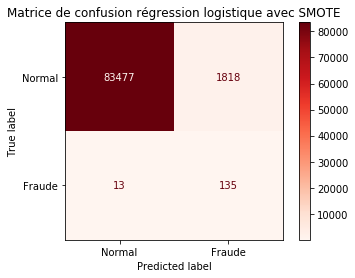

In [36]:
# Confusion matrix
np.set_printoptions(precision=2)

disp = plot_confusion_matrix(log_reg_smote,
                             X_test,
                             y_test,
                             display_labels=["Normal", "Fraude"],
                             values_format='.6g',
                             cmap=plt.cm.Reds,
                             normalize=None)
disp.ax_.set_title('Matrice de confusion régression logistique avec SMOTE')

plt.show()

In [37]:
roc_auc_reg_smote = roc_auc_score(y_test, predictions)
print('Roc Auc score', roc_auc_reg_smote)

Roc Auc score 0.945423949947955


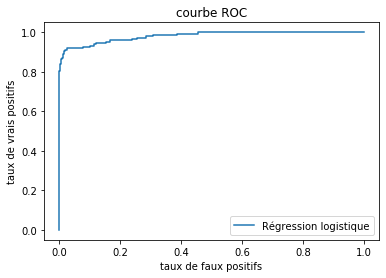

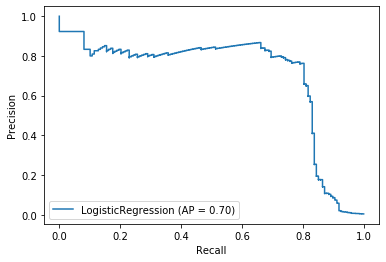

In [38]:
decision_function = log_reg_smote.decision_function(X_test)

# ROC curve
log_reg_fpr, log_reg_tpr, log_reg_thresholds = roc_curve(y_test, decision_function)

plt.title('courbe ROC')
plt.plot(log_reg_fpr, log_reg_tpr, label='Régression logistique')
plt.xlabel('taux de faux positifs')
plt.ylabel('taux de vrais positifs')
plt.legend(loc='best')
plt.show()

# Precision-Recall curve
plot_precision_recall_curve(log_reg_smote, X_test, y_test)

<a id="Vae"></a>
## 10 Sur-échantillonnage avec autoencodeur variationnel 


### 10.1 Théorie

Un auto-encodeur est un réseau de neurones entraîné pour reproduire ses entrées. Il composé de deux parties: un encodeur et un décodeur. L'encodeur est généralement un réseau de neurones dont le nombre de neurones des couches internes diminu proportionnellement à la profondeur du réseau jusqu'à une couche cachée **h** plus fine utilisée pour encoder une représentation condensée latente des entrées. Souvent symétrique à l'encodeur, le décodeur produit une reconstruction des entrées à partir de leurs représentations latentes. Le but principal est que l'encodage **h** capture les propriétés caractérisant la donnée d'entrée.

L'autoencodeur variationnel (VAE)[\[7\]](#Kingma) est une variante de l'autoencodeur utilisé pour générer des données. Le VAE contient deux composantes: le réseau d'inférence approchée $q(z|x)$ (l'encodeur) et le réseau génératif $p_{modèle}(x|z)$ (le décodeur) étant donné $p(z)$. Puisque ces deux composantes sont implémentées par des réseaux de neurones, ces distributions ne peuvent être qu'approximée, c'est pourquoi on dit que le VAE utilise l'inférence approchée apprise. En particulier l'inférence variatonnelle est utile lorsque l'évaluation de l'intégrale pour trouver l'évidence $p(x)$ en marginalisant $p(x,z)$ n'est pas analytique ou requiert un temps exponentiel.

$$
p(x) = \int{p(x,z)dz} = \int{p(x|z)p(z)dz}
$$

L'inférence variationnelle est utilisée pour approximer la vraie distribution $p(z|x)$ à partir d'une densité modélisée $q(z)$ sur les variables latentes. On utilise la divergence Kullback–Leibler $KL$ pour trouver une densité suffisamment proche de la vraie distribution conditionnelle:

$$
q^*(z) = argmin_{q(z)} KL( q(z) | p(z|x))
$$

où 

\begin{align*}
KL( q(z) | p(z|x)) &= \mathbb{E}_{q(z)}(ln\frac{q(z)}{p(z|x)}) \\
&= \mathbb{E}_{q(z)}(ln(q(z))) - \mathbb{E}_{q(z)}(ln(p(z,x))) + ln(p(x)), \\
\end{align*}

mais ce problème d'optimisation requiert le calcul de l'évidence $ln(p(x))$ qu'on a supposée difficile à calculer. Avec un peu de gymnastique on peut réarranger les termes pour dériver une borne inférieure pour la vraissemblance marginale $p(x)$:

\begin{align*}
ln(p(x)) &= KL( q(z) | p(z|x)) + \mathbb{E}_{q(z)}(ln(p(z,x))) - \mathbb{E}_{q(z)}(ln(q(z)))\\
&\geq \mathbb{E}_{q(z)}(ln(p(z,x))) - \mathbb{E}_{q(z)}(ln(q(z))) \\
&= \mathbb{E}_{q(z)}(ln(p(x|z))) + \mathbb{E}_{q(z)}(ln(p(z))) - \mathbb{E}_{q(z)}(ln(q(z))) \\
&= \mathbb{E}_{q(z)}(ln(p(x|z))) - \mathbb{E}_{q(z)}(ln(\frac{q(z)}{p(z)})) \\
&= \mathbb{E}_{q(z)}(ln(p(x|z))) - KL( q(z) | p(z) ).
\end{align*}

Le dernier membre de droite

$$
\mathbb{E}_{q(z)}(ln(p(x|z))) - KL( q(z) | p(z) ) = \mathbb{E}_{q(z)}(ln(p(z,x))) - \mathbb{E}_{q(z)}(ln(q(z))) = \mathbb{E}_{q(z)}(ln(\frac{p(z,x)}{q(z)}))
$$

est appelé la borne inférieure de l'évidence (ELBO) et son opposé est le problème de minimisation original de la divergence $KL$ plus $ln(p(x))$ qui est une constante relativement à $q(z)$. Par conséquent, le problème de minimisation original peut-être remplacé par le problème alternatif de maximisation de ELBO. 

Comme on voudrait pouvoir reconstruire une entrée $x$ à partir de son encodage latent correspondant $y$, il est raisonable de poser que la distribution du modèle $q(z)$ dépend explicitement de l'entrée $x$.

$$
q(z) := q(z|x)
$$

Dès lors, le problème de maximisation ELBO coïncide avec l'architecture de l'autoencodeur variationel. En pratique, on optimise l'estimation de

$$
ln(p(x|z)) + ln(p(z)) - ln(p(z|x)).
$$

Dans le cas d'autoencodeurs variationnels gaussiens, les distributions $q(z|x)$ et $p(z)$ sont supposées normales.

$$
q(z|x) \sim \mathcal{N}(\mu (x), \sigma^2(x))\\
p(z) \sim \mathcal{N}(0,1)
$$

Le vecteur $\mu(x)$ et la matrice diagonale $\sigma^2(x)$ de dimensions de l'espace latents sont prédits par le réseaux de neurones d'inférence. Pour évaluer ELBO, on peut utiliser le truc de reparamétrisation [\[7\]](#Kingma). La variable latente aléatoire $z \sim q(z|x)$ peut-être reparamétrée en une variable déterministe 

$$
z = g(\epsilon, x) = \mu(x) + \epsilon\sigma^2(x)
$$ 

avec $\epsilon$ une variable de bruit auxiliaire tirée d'une gaussienne centrée réduite.

Finalement, la fonction de coût associée à notre problème d'optimisation pour entraîner le réseau s'exprime comme

$$
\mathcal{L} =  KL( q(z|x) | p(z) ) - \frac{1}{N}\sum_1^Nln(p(y|m))
$$


### 10.2 Implémentation

L'implémentation ci-bas est inspirée par un exemple fourni sur TensorFlow [\[3\]](#tfVAE) et par l'exemple dans un article Medium [\[8\]](#mediumVAE).

La distribution $p(z)$ (prior) est une normale centrée réduite de la dimension de l'espace latent. Elle est implémentée avec `MultivariateNormalDiag`. Le vecteur de moyennes nulles est fourni au paramètre `loc` et la matrice de covariances est l'identité (les normales sont indépendantes).

L'encodeur est un réseaux de neurones dont le nombre de neurones diminue à chaque couche. On utilise `MultivariateNormalTriL.params_size` pour indiquer les dimensions de la dernière couche régulière complètement connectée du réseau. La dernière couche du réseaux est une couche `MultivariateNormalTril` qui paramétrise le vecteur de moyennes et la matrice triangulaire inférieure de covariances de $q(z|x)$. À cette étape, on ajoute la divergence $KL( q(z|x) | p(z) )$ au calcul de la fonction coût avec `KLDivergenceRegularizer`.

Le décodeur est aussi un réseaux de neurones complètement connecté mais sa dernière couche utilise `IndependentNormal` pour générer la sortie. 

Pour la fonction coût, on doit seulement calculer l'erreur de reconstruction parce que le terme de la divergence KL est spécifié dans l'encodeur. On calcul la log-vraissemblance négative de l'entrée étant donné la sortie.

In [39]:
# Reproductibility
np.random.seed(0)
tf.random.set_seed(0)

# Settings
original_dim = X_train.shape[1]
input_shape = X_train[0].shape
encoded_size = 2

# Prior 
prior = tfpd.MultivariateNormalDiag(
        loc=tf.zeros([encoded_size]), # Mu vector
        scale_identity_multiplier=1.0) # Scale 

# Regularizer that adds a KL divergence penalty to the model loss.
# Encourage marginal coherence with a unit-MVN (the "prior")
kl_divergence = tfpl.KLDivergenceRegularizer(prior)

# Loss - Negative Log-likelihood
neg_log_likelihood = lambda original_input, model_output: -model_output.log_prob(original_input)

# Encoder
inference_net = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape, name='encoder_input'),
    tfkl.Dense(20, activation='relu'),
    tfkl.Dense(10, activation='relu'),
    tfkl.Dense(5, activation='relu'),
    # full-covariance Gaussian distribution, 
    # with its mean and covariance matrices parameterized by the output of a neural network.
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size), activation=None),
    # precedent output has a shape: encoded_size + encoded_size * (encoded_size + 1) // 2
    tfpl.MultivariateNormalTriL(  # Latent space
    encoded_size,
    activity_regularizer=kl_divergence)
], name='Encoder')

# Decoder
generative_net = tfk.Sequential([
    tfkl.InputLayer(input_shape=encoded_size, name='decoder_input'),
    tfkl.Dense(5, activation='relu'),
    tfkl.Dense(10, activation='relu'),
    tfkl.Dense(20, activation='relu'),
    tfkl.Dense(tfpl.IndependentNormal.params_size(original_dim), activation=None),
    tfpl.IndependentNormal(original_dim),
], name='Decoder')

# Variational auto-encoder
vae = tfk.Model(inputs=inference_net.inputs,
                outputs=generative_net(inference_net.outputs[0]),
                name='Variational_Autoencoder')

# Optimizer
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
vae.compile(optimizer=optimizer, loss=neg_log_likelihood)

vae.summary()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "Variational_Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 20)                620       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 30        
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 2), (None, 2))    0         
______________________



<img src="model.PNG" alt="model" style="width:400px;height:500px;">


On veut que le réseau apprenne la distribution des transactions frauduleuses. C'est pourquoi on l'entraîne exclusivement sur des fraudes. 

La méthode `from_tensor_slices` découpe les tenseurs en argument selon leur première dimension. Cette opération paire un exemple avec lui même pour calculer l'erreur de reconstruction dans la fonction perte du réseau. 

In [40]:
# Training settings
BATCH_SIZE = 32
MAX_EPOCHS = 1000 # for early stopping

# Train - Val split for VAE
X_train_vae, X_val_vae, y_train_vae, y_val_vae = train_test_split(X_train,
                                                                  y_train,
                                                                  test_size=0.3,
                                                                  random_state=0,
                                                                  stratify=y_train)

# Training on fraud instances
X_fraud_train = X_train_vae[y_train_vae == 1]
X_fraud_val = X_val_vae[y_val_vae == 1]

tf_train = tf.data.Dataset.from_tensor_slices((X_fraud_train, X_fraud_train)).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e4))
tf_val = tf.data.Dataset.from_tensor_slices((X_fraud_val, X_fraud_val)).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e4))

Le défi est d'apprendre la distribution des fraudes, mais en disposant seulement de très peu de données. L'ensemble d'entraînement a une grande variabilité et le modèle risque de sur-ajuster les données d'entraînement. 

L'arrêt précoce (early stopping) est une forme de régularisation qu'on peut utiliser pour éviter le sur-apprentissage. 
Cette technique consiste à cesser l'entraînement du modèle lorsque que le coût relatif à l'ensemble de validation n'a pas diminué significativement pour quelques époques, et ce, même si le coût relatif à l'entraînement continu de diminuer. 

<img src="early stopping.PNG" alt="early stopping" style="width:500px;height:350px;">

[Source](#neural)

Le nombre d'époques est le nombre de passes de l'algorithme d'optimisation dans l'ensemble d'entraînement. Cette quantité peut-être vue comme un hyperparamètre qui contrôle l'expressivité du modèle. C'est pourquoi l'arrêt précoce a pour effet de ne pas coller trop aux données d'entraînement. Il donne une idée du nombre d'itérations qui peuvent être faites avant de commencer à sur-apprendre.

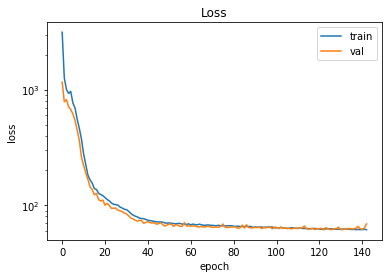

In [41]:
# Stop training when a monitored quantity (here validation loss) has stopped improving.
earlystopper = EarlyStopping(monitor='val_loss',
                             mode='min',
                             min_delta=0.005,
                             patience=20, # Training stops when val_loss fails to decrease for 20 consecutive epochs
                             verbose=0,
                             restore_best_weights=True)

# Training
hist = vae.fit(tf_train,
               epochs=MAX_EPOCHS,
               shuffle=True,
               verbose=0,
               validation_data=tf_val,
               callbacks=[earlystopper])

# Plot training history
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.yscale('log',basey=10)
plt.show()

Comme la dimension d'encodage choisie est 2, on peut visualiser les moyennes et les écarts-types modélisés par le réseau d'inférence $q(z|x)$. En regardant les graphiques, on voit que le réseau d'inférence semble distinguer les fraudes des transactions normales.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



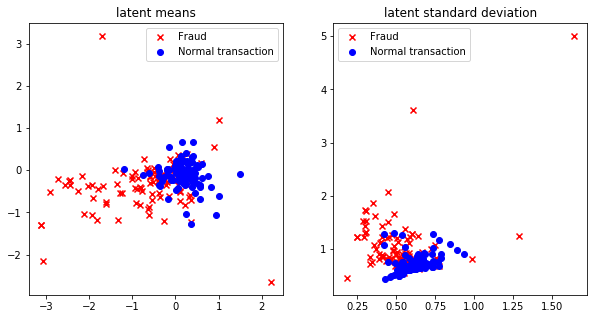

In [42]:
X_frauds = X_val_vae[y_val_vae == 1]
n_frauds = X_frauds.shape[0]
X_non_frauds = X_val_vae[y_val_vae == 0][:n_frauds]
q = inference_net(np.concatenate([X_frauds, X_non_frauds]))

plt.figure(figsize=(10, 5))

# mean
plt.subplot(121)
latent_mean = q.mean()
plt.scatter(latent_mean[:n_frauds, 0], latent_mean[:n_frauds, 1], c='r', marker='x', label='Fraud')
plt.scatter(latent_mean[n_frauds:, 0], latent_mean[n_frauds:, 1], c='b', marker='o', label='Normal transaction')
plt.legend(loc='best')
plt.title('latent means')

# std
plt.subplot(122)
latent_mean = q.stddev()
plt.scatter(latent_mean[:n_frauds, 0], latent_mean[:n_frauds, 1], c='r', marker='x', label='Fraud')
plt.scatter(latent_mean[n_frauds:, 0], latent_mean[n_frauds:, 1], c='b', marker='o', label='Normal transaction')
plt.legend(loc='best')
plt.title('latent standard deviation')

plt.show()

Pour générer de nouveaux cas de fraudes, on doit fournir un vecteur aléatoire au model génératif. Comme on a supposé que $p(z)$ est de distribution normale centrée réduite, ce vecteur aléatoire doit ête échantillonné selon cette distribution. 

In [43]:
# Generates new examples
def sample(generator, encoded_size, n_samples):
    z = tf.random.normal(shape=(n_samples, encoded_size))
    return generator.predict(z)

Ci-dessous une visualisation des données originales et des données synthétiques créées par le réseau génératif de l'autoencodeur variationnel. La méthode de réduction de dimensionalité T-sne projette les 30 traits caractéristiques d'une transaction sur 2 composantes pour rendre la visualisation possible.

On remarque que les fraudes et les transactions synthétiques générées par le réseau génératif sont dans un même groupement, ce qui suggère que l'autoencodeur variationnel a appris la distribution des fraudes.

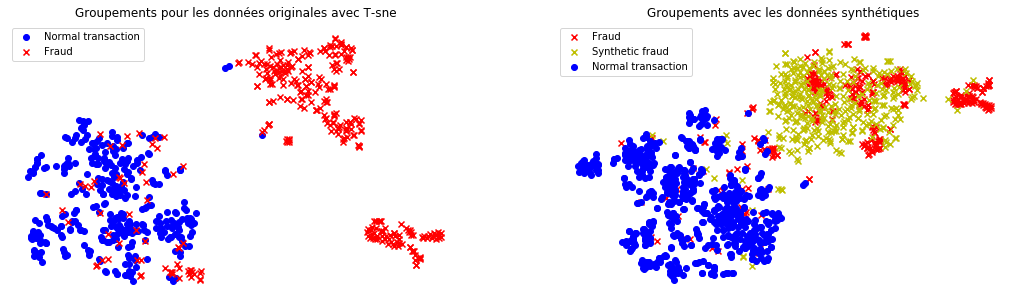

In [44]:
plt.figure(figsize=(18, 5))

# Original data 
plt.subplot(121)

X, y = X_train, y_train
X_train_fraud= X[y == 1]
y_train_fraud = y[y == 1]
n_fraud = X_train_fraud.shape[0]
X_train_non_fraud = X[y == 0][: n_fraud]
y_train_non_fraud = y[y == 0][: n_fraud]
X_to_plot = np.concatenate([X_train_fraud, X_train_non_fraud])
y_to_plot = np.concatenate([y_train_fraud, y_train_non_fraud])

tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_to_plot)

plt.scatter(X_tsne[y_to_plot == 0, 0],
            X_tsne[y_to_plot == 0, 1],
            marker='o',
            color='b',
            label='Normal transaction')
plt.scatter(X_tsne[y_to_plot == 1, 0],
            X_tsne[y_to_plot == 1, 1],
            marker='x',
            color='r',
            label='Fraud')
plt.title('Groupements pour les données originales avec T-sne')
plt.legend(loc='best')
plt.axis(False)

# Synthetic data
plt.subplot(122)

original_frauds = X_train[y_train == 1]
n_frauds = original_frauds.shape[0]
synth_frauds = sample(generative_net, 2, n_frauds)
non_frauds = X_train[y_train == 0][: 2*n_frauds]
X_to_plot = np.concatenate([original_frauds, synth_frauds, non_frauds])

tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_to_plot)

plt.scatter(X_tsne[:n_frauds, 0], X_tsne[:n_frauds, 1], marker='x', color='r', label='Fraud')
plt.scatter(X_tsne[n_frauds:2*n_frauds, 0], X_tsne[n_frauds:2*n_frauds, 1], marker='x', color='y', label='Synthetic fraud')
plt.scatter(X_tsne[2*n_frauds:, 0], X_tsne[2*n_frauds:, 1], marker='o', color='b', label='Normal transaction')
plt.title('Groupements avec les données synthétiques')
plt.legend(loc='best')
plt.axis(False)

plt.show()

### 10.3 Régression logistique

Ci-bas la performance de la régression logistique entraînée avec les exemples synthétiques. À la différence des méthodes précédentes, cette méthode de sur-échantillonnage permet d'avoir une meilleure précision. En effet, bien que le rappel est un peu inférieur pour la classe de fraudes, le score f1 est nettement supérieur. Les performance relatives à la classe de transactions normales sont excellentes, de sorte que cette méthode est favorable si on souhaite ne pas déranger des clients inutilement.

In [45]:
n_samples = X_train[y_train == 0].shape[0] - X_train[y_train == 1].shape[0]
X_synthetic_frauds = sample(generative_net, 2, n_samples)
y_synthetic_frauds = np.ones(n_samples)

X_train_vae = np.concatenate([X_train, X_synthetic_frauds])
y_train_vae = np.concatenate([y_train, y_synthetic_frauds])

In [46]:
log_reg = LogisticRegression()

# Tuning penalty and regularization using cross validation (5 folds)
params = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
# Using accuracy as since the validation set is balanced
log_reg = GridSearchCV(log_reg, params, scoring='accuracy', cv=5, verbose=1) 
log_reg.fit(X_train_vae, y_train_vae)
print('Meilleurs paramètres:', log_reg.best_params_)
print('Meilleur résultat (moyenne des résultats de validation croisée):', log_reg.best_score_)
log_reg_vae = log_reg.best_estimator_

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  1.1min finished


Meilleurs paramètres: {'C': 10, 'penalty': 'l2'}
Meilleur résultat (moyenne des résultats de validation croisée): 0.9976962114360365


In [47]:
log_reg_vae.fit(X_train_vae, y_train_vae)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
# Evaluation on test set
pred = log_reg_vae.predict(X_test)
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.999     1.000     85295
           1      0.710     0.811     0.757       148

    accuracy                          0.999     85443
   macro avg      0.855     0.905     0.878     85443
weighted avg      0.999     0.999     0.999     85443



In [49]:
print(roc_auc_score(y_test, pred))

0.9051181669975269


## 11 Détection d'anomalies VAE

Les auto-encodeurs peuvent être utilisés pour établir directement une classification dans le cadre d'un apprentissage non-supervisé (sans classe).

Si un auto-encodeur s'entraîne seulement sur les transactions normales, alors il va apprendre à les reproduire. De là on s'attend à ce qu'il éprouve des difficultés à reproduire fidèlement les cas de fraudes puisque ses poids ont été appris en fonction des transactions normales. Pour cette raison, le coût de reconstruction devrait être élevé pour les fraudes de sorte qu'on peut classifier les transactions en fonction d'un seuil critique du coût de reconstruction. 

In [50]:
# Reproductibility
np.random.seed(0)
tf.random.set_seed(0)

# Settings
original_dim = X_train.shape[1]
input_shape = X_train[0].shape
encoded_size = 2

# Prior 
prior = tfpd.MultivariateNormalDiag(
        loc=tf.zeros([encoded_size]), # Mu vector
        scale_identity_multiplier=1.0) # Scale 

# Regularizer that adds a KL divergence penalty to the model loss.
# Encourage marginal coherence with a unit-MVN (the "prior")
kl_divergence = tfpl.KLDivergenceRegularizer(prior)

# Loss - Negative Log-likelihood
neg_log_likelihood = lambda original_input, model_output: -model_output.log_prob(original_input)

# Encoder
inference_net = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape, name='encoder_input'),
    tfkl.Dense(20, activation='relu'),
    tfkl.Dense(10, activation='relu'),
    tfkl.Dense(5, activation='relu'),
    # full-covariance Gaussian distribution, 
    # with its mean and covariance matrices parameterized by the output of a neural network.
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size), activation=None),
    tfpl.MultivariateNormalTriL(  # Latent space
    encoded_size,
    activity_regularizer=kl_divergence)
], name='Encoder')

# Decoder
generative_net = tfk.Sequential([
    tfkl.InputLayer(input_shape=encoded_size, name='decoder_input'),
    tfkl.Dense(5, activation='relu'),
    tfkl.Dense(10, activation='relu'),
    tfkl.Dense(20, activation='relu'),
    tfkl.Dense(tfpl.IndependentNormal.params_size(original_dim), activation=None),
    tfpl.IndependentNormal(original_dim),
], name='Decoder')

# Variational auto-encoder
vae = tfk.Model(inputs=inference_net.inputs,
                outputs=generative_net(inference_net.outputs[0]),
                name='Variational_Autoencoder')

# Optimizer
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
vae.compile(optimizer=optimizer, loss=neg_log_likelihood)

vae.summary()

Model: "Variational_Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 30)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 30        
_________________________________________________________________
multivariate_normal_tri_l_1  ((None, 2), (None, 2))    0         
_________________________________________________________________
Decoder (Sequential)         (None, 30)    

In [51]:
# Train - val - split 
X_train_fraud, X_train_norm = X_train[y_train == 1], X_train[y_train == 0]

X_train_vae, X_val_vae = train_test_split(X_train_norm, test_size=0.3, shuffle=False)

# We can add the remaining frauds to the test set 
# Todo

print(X_train_vae.shape, X_val_vae.shape)

(139314, 30) (59706, 30)


In [52]:
batch_size = 128
max_epochs = 1000
tf_train = tf.data.Dataset.from_tensor_slices((X_train_vae, X_train_vae)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e4))
tf_val = tf.data.Dataset.from_tensor_slices((X_val_vae, X_val_vae)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e4))

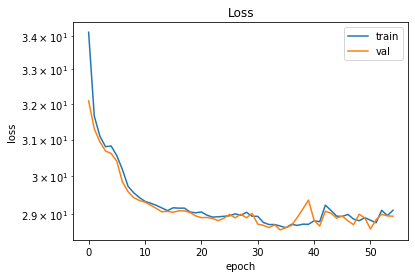

In [53]:
# Training
earlystopper = EarlyStopping(monitor='val_loss',
                             mode='min',
                             min_delta=0.005,
                             patience=20,
                             verbose=0,
                             restore_best_weights=True)

hist = vae.fit(tf_train,
               epochs=max_epochs,
               shuffle=True,
               verbose=0,
               validation_data=tf_val,
               callbacks=[earlystopper])

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.yscale('log',basey=10)
plt.show()

Comme mentionné précédemment, pour pouvoir classifier, il faut définir une métrique pour quantifier l'erreur ou le coût de reconstruction à la sortie de l'autoencodeur variationnel.

La fonction suivante retourne la probabilité que la sortie du réseau soit générée par son entrée. Une probabilité de reconstruction élevée devrait correspondre à une transaction normale tandis qu'une faible probabilité de reconstruction devrait correspondre à une fraude parce que les poids du réseaux sont optimisés en fonction des transactions normales.

In [54]:
def reconstruction_prob(X, n_samples):
    # Multivariate Normal 
    encoder_out = inference_net(X) # Output tensor, .predict() outputs a numpy array
    # Sample n_samples from this distribution
    encoder_samples = encoder_out.sample(n_samples)
    # Generate new example from theses random samples 
    generated_examples = generative_net(encoder_samples)
    # Log probability (and not .prob to avoid floating arithmetic error) density/mass function.
    reconstruction_log_prob = np.mean(generated_examples.log_prob(X), axis=0)
    return reconstruction_log_prob


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



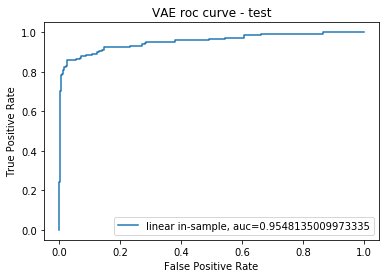

In [55]:
# Number of sampled examples of the triangular Gaussian for each input.
n_samples = 10  # For stability

reconstruction_log_prob = reconstruction_prob(X_test, n_samples)

fp_rate, tp_rate, thresholds = roc_curve(y_test, -reconstruction_log_prob)
auc = roc_auc_score(y_test, -reconstruction_log_prob)

plt.plot(fp_rate,tp_rate,label="linear in-sample, auc="+str(auc))
plt.title('VAE roc curve - test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

Pour déterminer un seuil pour la classification en fonction de la probabilité de reconstruction, on peut utiliser une méthode basée sur la cote Z, mais qui utilise la médiane (MAD) plutôt que la moyenne pour éviter que les anomalies influencent elles-même la métrique par rapport à laquelle elles seront choisies. 

Soit $m$ la médiane. On appelle $MAD$ la médiane de la différence en valeur absolue entre les point $x_i$ et $m$

$$
MAD = médianne\{|x_i-m|\}.
$$

Pour un point $x_i$, on calcule sa cote Z modifiée de la façon suivante:

$$
    Z_i = \frac{0.6745(x_i - m)}{MAD}.
$$

La quantité $0.6745$ représente le $75$e quartile d'une distribution normale (MAD converge vers cette distribution). 

Contrairement aux méthodes basées sur les centiles, la cote Z modifiée a l'avantage d'être indépendante du nombre de données.

In [56]:
# Implentation is inspired by this notebook https://www.kaggle.com/robinteuwens/anomaly-detection-with-auto-encoders
def compute_mad_z_scores(points):  
    m = np.median(points, axis=0)
    abs_deviation = np.abs(points - m)
    m_abs_deviation = np.median(abs_deviation)
    modified_z_score = 0.6745 * abs_deviation / m_abs_deviation
    return modified_z_score

In [57]:
Z_SCORE_THRESHOLD = 2.5
mad_z_scores = compute_mad_z_scores(-reconstruction_log_prob)
mad_outliers = (mad_z_scores > Z_SCORE_THRESHOLD).astype(int)
n_outliers = len(mad_outliers[mad_outliers==True])
print(f'This results in {n_outliers:,} detected anomalies, or {n_outliers/len(y_test)*100:.2f}% out of {len(y_test):,} trades reported.')

This results in 1,407 detected anomalies, or 1.65% out of 85,443 trades reported.


La performance sur les données tests est inférieure à celle obtenue précédemment avec l'apprentissage supervisé. 

In [58]:
from sklearn.metrics import confusion_matrix

# get (mis)classification
cm = confusion_matrix(y_test, mad_outliers)
print(f'The classifications using the MAD method with threshold={Z_SCORE_THRESHOLD} are as follows:\n{cm}\n')
print(f'Fraud caught successfully (recall):\n{cm[1,1]} / ({cm[1,0]} + {cm[1,1]}) = {cm[1,1] / (cm[1,0] + cm[1,1]) * 100:.2f}%')

The classifications using the MAD method with threshold=2.5 are as follows:
[[84008  1287]
 [   28   120]]

Fraud caught successfully (recall):
120 / (28 + 120) = 81.08%


In [59]:
print(classification_report(y_test, mad_outliers, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.985     0.992     85295
           1      0.085     0.811     0.154       148

    accuracy                          0.985     85443
   macro avg      0.542     0.898     0.573     85443
weighted avg      0.998     0.985     0.991     85443



## Références

[1] Blei, D., Kucukelbir, A. et McAuliffe, J. (2018). Variational Inference: A Review for Statisticians. arXiv:1601.00670.

<a id="smote"></a>
[2] Chawla, N., Bowyer, K., Hall, L. et Kegelmeyer, P. (2002). SMOTE: Synthetic Minority Over-sampling Technique. arXiv:1106.1813.

<a id="tfVAE"></a>
[3] Convolutional Variational Autoencoder. TensorFlow. https://www.tensorflow.org/tutorials/generative/cvae

[4] Fajardo, V., Findlay, D., Houmanfar, R., Jaiswal, C., Liang, J. et Xie, H. (2018). VOS: a Method for Variational Oversampling of Imbalanced Data. arXiv:1809.02596.

<a id="neural"></a>
[5] Guillaume, R. (2019). IFT3395 : Neural Networks \[notes de cours\]. StudiUM. https://studium.umontreal.ca/

<a id="Adasyn"></a>
[6] Haibo H., Yang B., Edwardo A. G., et Shutao L. (2008). ADASYN: Adaptive Synthetic Sampling Approach for Imbalanced Learning

<a id="Kingma"></a>
[7] Kingma, D. et Welling, M. (2014). Auto-Encoding Variational Bayes. arXiv:1312.6114.

<a id="mediumVAE"></a>
[8] TFP Team. (2019).Variational Autoencoders with Tensorflow Probability Layers. Medium
https://medium.com/tensorflow/variational-autoencoders-with-tensorflow-probability-layers-d06c658931b7